In [1]:
# 基础数据科学运算库
import numpy as np
import pandas as pd

# 可视化库
import seaborn as sns
import matplotlib.pyplot as plt

# 时间模块
import time

# sklearn库
# 数据预处理
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# 实用函数
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

# 常用评估器
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# 网格搜索
from sklearn.model_selection import GridSearchCV

# 自定义评估器支持模块
from sklearn.base import BaseEstimator, TransformerMixin

import warnings
warnings.filterwarnings('ignore')

# 自定义模块
from telcoFunc import *


## 模型训练

### 1.逻辑回归模型训练

In [2]:
# 读取数据
tcc = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
# 标注连续/离散字段
# 离散字段
category_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
                'PaymentMethod']

# 连续字段
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# 标签
target = 'Churn'

# ID列
ID_col = 'customerID'

# 验证是否划分能完全
assert len(category_cols) + len(numeric_cols) + 2 == tcc.shape[1]

In [4]:
tcc['TotalCharges']= tcc['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)
tcc['MonthlyCharges'] = tcc['MonthlyCharges'].astype(float)

In [5]:
tcc['TotalCharges'] = tcc['TotalCharges'].fillna(0)

In [6]:
tcc['Churn'].replace(to_replace='Yes', value=1, inplace=True)
tcc['Churn'].replace(to_replace='No',  value=0, inplace=True)

In [7]:
train, test = train_test_split(tcc, test_size=0.3, random_state=21)

In [8]:
X_train = train.drop(columns=[ID_col, target]).copy()
y_train = train['Churn'].copy()
X_test = test.drop(columns=[ID_col, target]).copy()
y_test = test['Churn'].copy()

In [9]:
assert len(category_cols) + len(numeric_cols) == X_train.shape[1]

logistic_pre = ColumnTransformer([
    ('cat', preprocessing.OneHotEncoder(drop='if_binary'), category_cols), 
    ('num', 'passthrough', numeric_cols)
])

logistic_model = LogisticRegression(max_iter=int(1e8))

logistic_pipe = make_pipeline(logistic_pre, logistic_model)

In [10]:
logistic_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', 'passthrough',
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('logisticregression', LogisticRegression(max_iter=100000000))])

In [11]:
def result_df(model, X_train, y_train, X_test, y_test, metrics=
              [accuracy_score, recall_score, precision_score, f1_score, roc_auc_score]):
    res_train = []
    res_test = []
    col_name = []
    for fun in metrics:
        res_train.append(fun(model.predict(X_train), y_train))
        res_test.append(fun(model.predict(X_test), y_test)) 
        col_name.append(fun.__name__)
    idx_name = ['train_eval', 'test_eval']
    res = pd.DataFrame([res_train, res_test], columns=col_name, index=idx_name)
    return res

In [12]:
result_df(logistic_pipe, X_train, y_train, X_test, y_test)

,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
train_eval,0.808722,0.669065,0.564064,0.612094,0.759231
test_eval,0.793185,0.615542,0.547273,0.579403,0.731108


### 2.逻辑回归的超参数调优

观察到标签的比例大致为1:3，有轻微的不平衡现象，但是并没有明显的不平衡，所以评价指标选用“accuracy”。若是标签严重不平衡，应选用“f1-Score”。

In [2]:
# 设置转化器流
logistic_pre = ColumnTransformer([
    ('cat', preprocessing.OneHotEncoder(drop='if_binary'), category_cols), 
    ('num', 'passthrough', numeric_cols)
])

num_pre = ['passthrough', preprocessing.StandardScaler(), preprocessing.KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')]

# 实例化逻辑回归评估器
logistic_model = LogisticRegression(max_iter=int(1e8))

# 设置机器学习流
logistic_pipe = make_pipeline(logistic_pre, logistic_model)

# 设置超参数空间
logistic_param = [
    {'columntransformer__num':num_pre, 'logisticregression__penalty': ['l1'], 'logisticregression__C': np.arange(0.1, 2.1, 0.1).tolist(), 'logisticregression__solver': ['saga']}, 
    {'columntransformer__num':num_pre, 'logisticregression__penalty': ['l2'], 'logisticregression__C': np.arange(0.1, 2.1, 0.1).tolist(), 'logisticregression__solver': ['lbfgs', 'newton-cg', 'sag', 'saga']}, 
]

# 实例化网格搜索评估器
logistic_search = GridSearchCV(estimator = logistic_pipe,
                                  param_grid = logistic_param,
                                  n_jobs = 12)

s = time.time()
logistic_search.fit(X_train, y_train)
print(time.time()-s, "s")

NameError: name 'ColumnTransformer' is not defined

逻辑回归训练时间为132.11778092384338 s

In [14]:
logistic_search.best_score_

0.8044624746450303

In [15]:
logistic_search.best_params_

{'columntransformer__num': 'passthrough',
 'logisticregression__C': 0.1,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'newton-cg'}

In [16]:
result_df(logistic_search.best_estimator_, X_train, y_train, X_test, y_test)

,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
train_eval,0.807505,0.667269,0.559515,0.608660,0.757667
test_eval,0.795551,0.622407,0.545455,0.581395,0.734563


### 3.逻辑回归模型解释

In [17]:
coe = logistic_search.best_estimator_.named_steps['logisticregression'].coef_
coe = coe.flatten()
coe

array([-3.88361094e-02,  2.58698811e-01, -7.72583000e-02, -1.81123736e-01,
       -3.09627587e-01, -2.87005004e-01,  3.09627827e-01, -2.26225836e-02,
       -2.69271683e-01,  3.15106437e-01, -4.58345142e-02,  2.39505981e-01,
       -4.58345142e-02, -1.93671226e-01,  7.70793274e-02, -4.58345142e-02,
       -3.12445732e-02,  9.18470285e-02, -4.58345142e-02, -4.60122743e-02,
        2.14614013e-01, -4.58345142e-02, -1.68779258e-01, -4.99378282e-02,
       -4.58345142e-02,  9.57725824e-02, -3.95944358e-02, -4.58345142e-02,
        8.54291900e-02,  6.02855870e-01, -1.99893716e-02, -5.82866258e-01,
        3.32742186e-01, -5.71536993e-02, -1.35744424e-01,  3.16755829e-01,
       -1.23857466e-01, -6.65008555e-02,  7.34408462e-03,  3.88776486e-04])

In [18]:
tf = logistic_search.best_estimator_.named_steps['columntransformer'].named_transformers_['cat']
tf

OneHotEncoder(drop='if_binary')

In [19]:
def cate_colName(Transformer, category_cols, drop='if_binary'):
    """
    离散字段独热编码后字段名创建函数
    
    :param Transformer: 独热编码转化器
    :param category_cols: 输入转化器的离散变量
    :param drop: 独热编码转化器的drop参数
    """
    
    cate_cols_new = []
    col_value = Transformer.categories_
    
    for i, j in enumerate(category_cols):
        if (drop == 'if_binary') & (len(col_value[i]) == 2):
            cate_cols_new.append(j)
        else:
            for f in col_value[i]:
                feature_name = str(j) + '_' + str(f)
                cate_cols_new.append(feature_name)
    return(cate_cols_new)

In [20]:
category_cols_new = cate_colName(tf, category_cols)

cols_new = category_cols_new + numeric_cols

assert len(cols_new) == len(coe)

In [21]:
weights = pd.Series(coe, index=cols_new)
weights

gender                                    -0.038836
SeniorCitizen                              0.258699
Partner                                   -0.077258
Dependents                                -0.181124
PhoneService                              -0.309628
MultipleLines_No                          -0.287005
MultipleLines_No phone service             0.309628
MultipleLines_Yes                         -0.022623
InternetService_DSL                       -0.269272
InternetService_Fiber optic                0.315106
InternetService_No                        -0.045835
OnlineSecurity_No                          0.239506
OnlineSecurity_No internet service        -0.045835
OnlineSecurity_Yes                        -0.193671
OnlineBackup_No                            0.077079
OnlineBackup_No internet service          -0.045835
OnlineBackup_Yes                          -0.031245
DeviceProtection_No                        0.091847
DeviceProtection_No internet service      -0.045835
DeviceProtec

<Axes: >

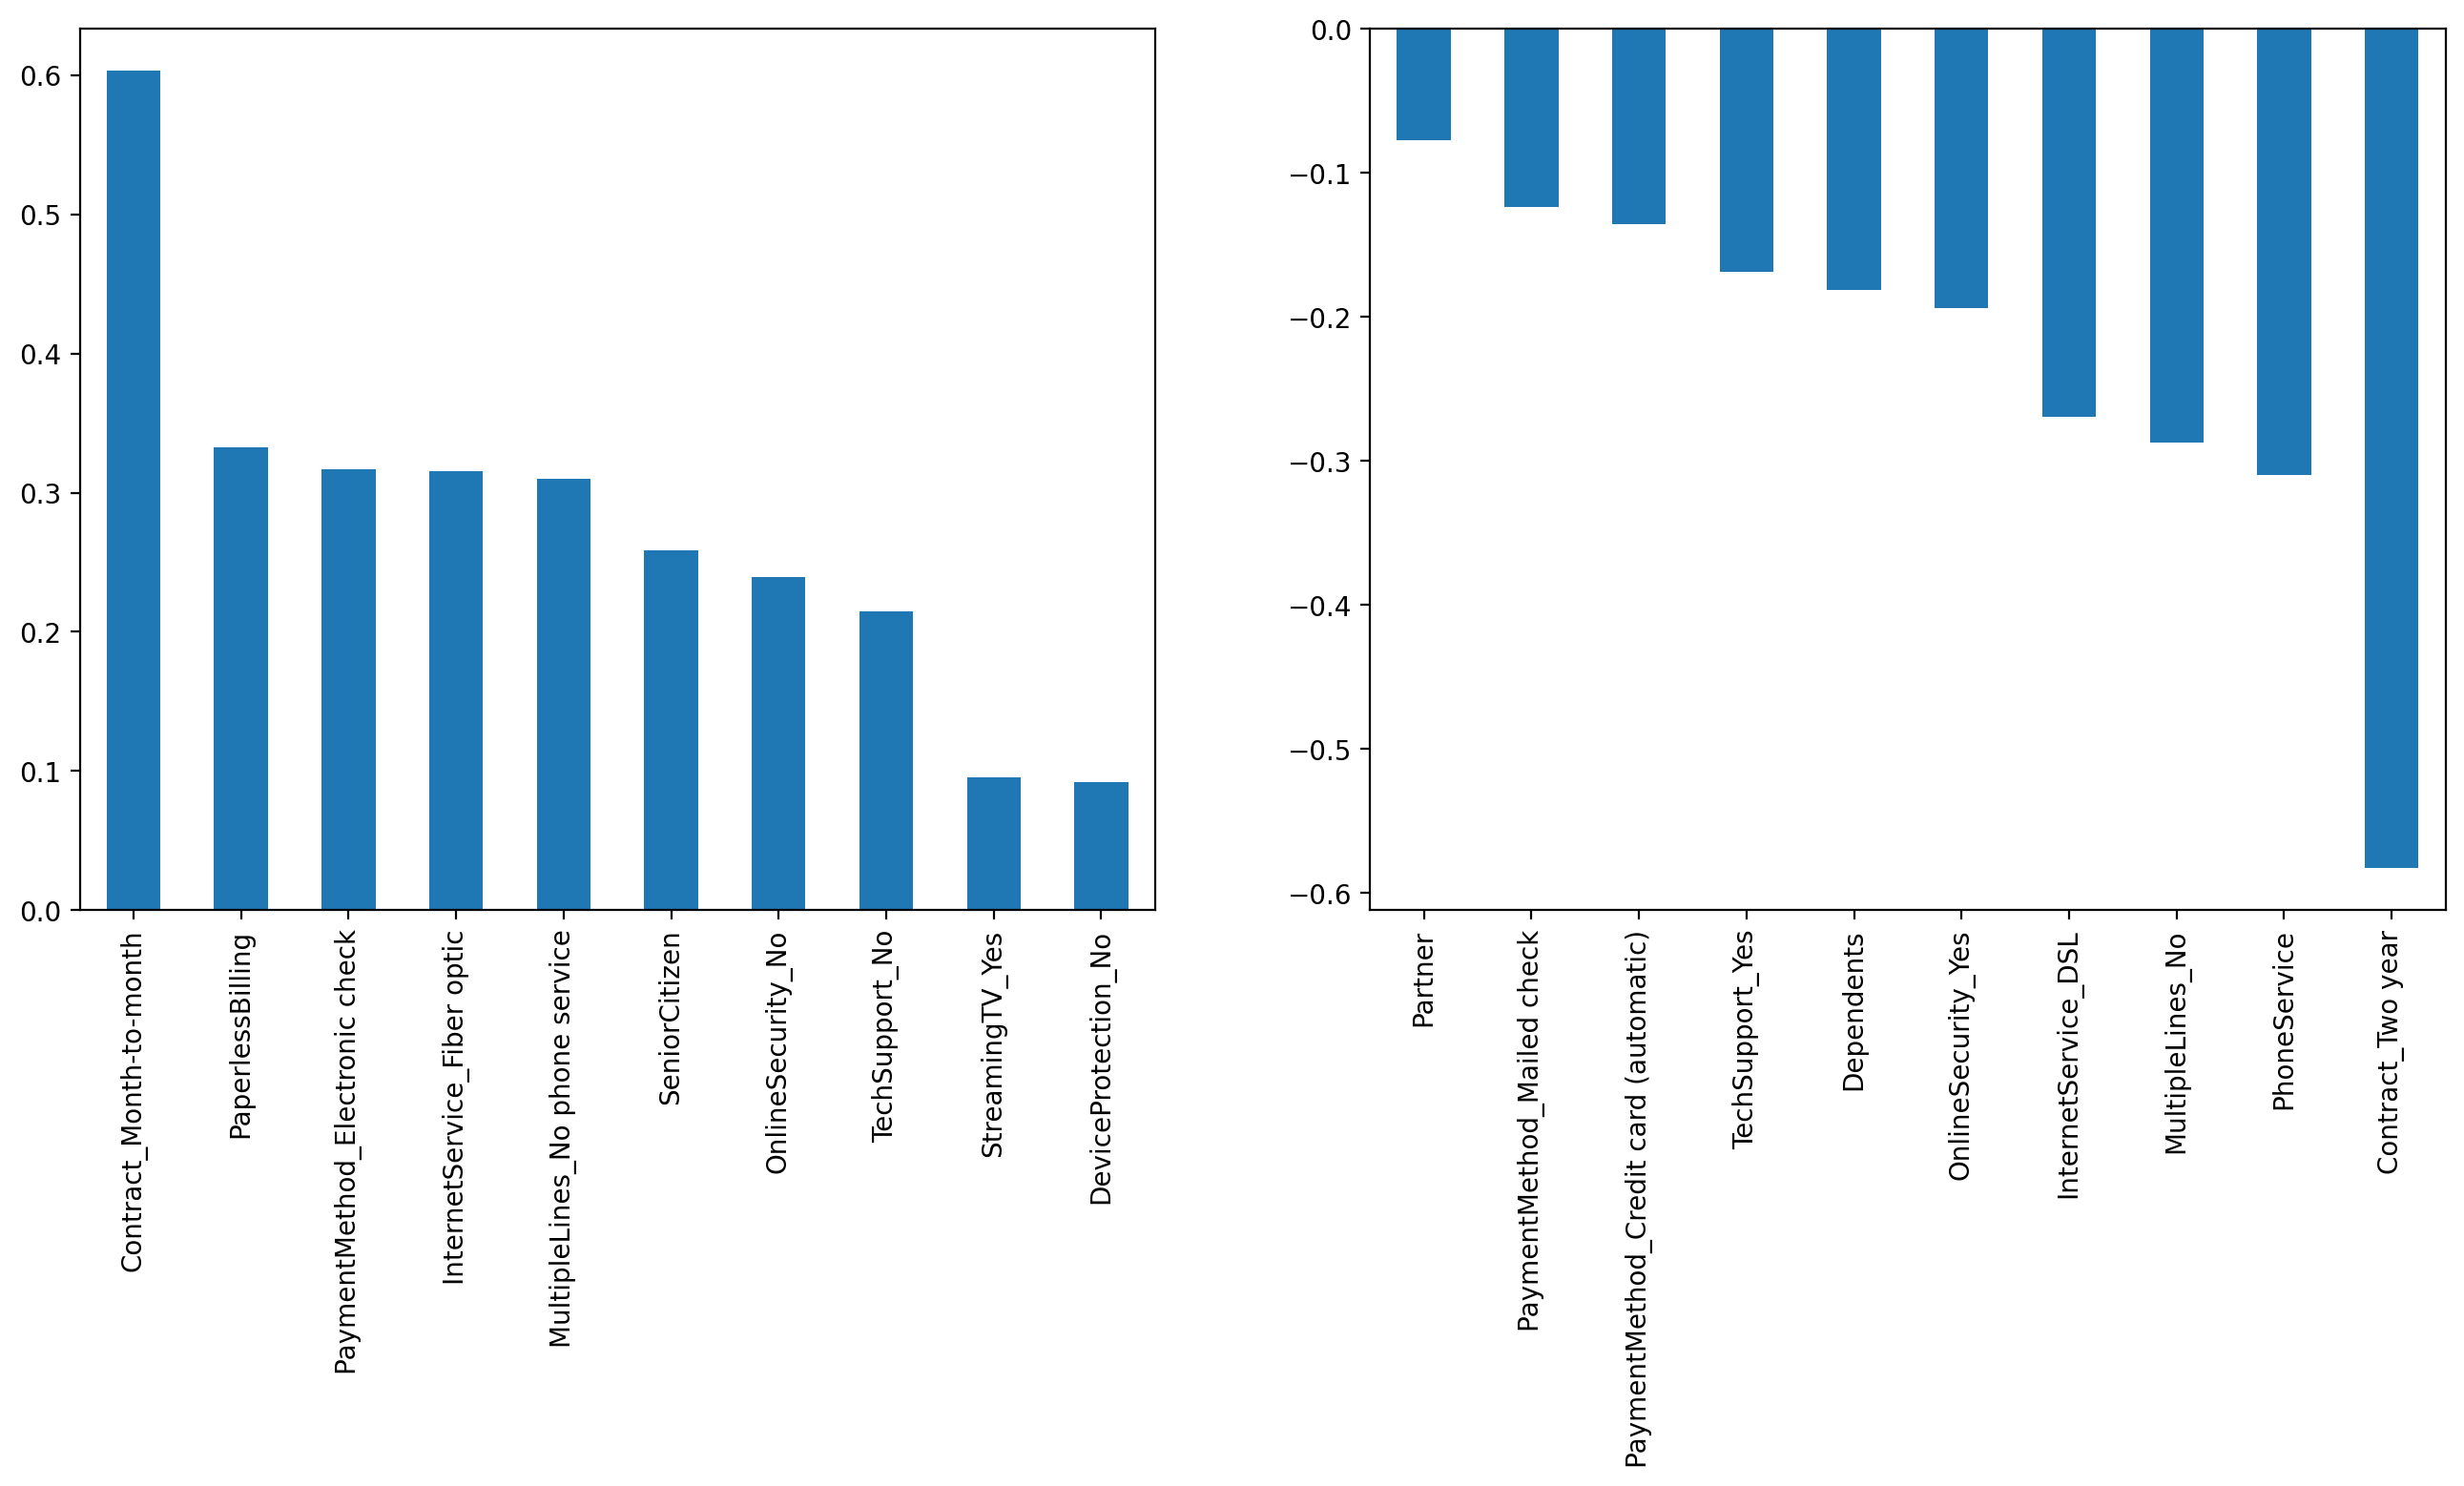

In [22]:
plt.figure(figsize=(16, 6), dpi=200)


plt.subplot(121)
weights.sort_values(ascending = False)[:10].plot(kind='bar')


plt.subplot(122)
weights.sort_values(ascending = False)[-10:].plot(kind='bar')

When the "Contract" field is "Month-to-month," there is a higher likelihood of user churn, whereas when "Contract" appears as "Two year," there is a greater likelihood of user retention. For the "Contract" field, the appearance of "Month-to-month" increases the log odds of user churn by 60%, while the appearance of "Two year" decreases the log odds of user churn by 60%. Among the factors leading to user churn, the impact of 'Contract_Month-to-month' is about two to three times that of 'SeniorCitizen', meaning the risk of user churn caused by engaging in month-to-month payment behavior is two to three times the risk caused by the user being a senior citizen.

Contract出现Month-to-month时，用户流失可能性较大，而Contract出现Two year时，用户留存可能性较大。对于Contract字段来说，Month-to-month出现时会让用户流失的对数几率增加60%，而Two year出现时会让用户流失的对数几率减少60%。在导致用户流失的因素中，'Contract_Month-to-month'的影响约为'SeniorCitizen'的两到三倍，或用户签订协约时出现月付行为所造成的用户流失风险，是用户是老年人导致的风险的两到三倍。

### 4.决策树模型训练

对于决策树来说，由于并没有类似线性方程的数值解释，因此无需对分类变量进行独热编码转化，直接进行自然数转化

In [23]:
# 导入决策树评估器
from sklearn.tree import DecisionTreeClassifier

# 设置转化器流
tree_pre = ColumnTransformer([
    ('cat', preprocessing.OrdinalEncoder(), category_cols), 
    ('num', 'passthrough', numeric_cols)
])

# 实例化决策树评估器
tree_model = DecisionTreeClassifier()

# 设置机器学习流
tree_pipe = make_pipeline(tree_pre, tree_model)

In [24]:
# 模型训练
tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', 'passthrough',
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [25]:
result_df(tree_pipe, X_train, y_train, X_test, y_test)

,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
train_eval,0.998986,1.000000,0.996209,0.998101,0.999309
test_eval,0.740653,0.501767,0.516364,0.508961,0.664911


### 5.决策树超参数调优

In [26]:
tree_pre = ColumnTransformer([
    ('cat', preprocessing.OrdinalEncoder(), category_cols), 
    ('num', 'passthrough', numeric_cols)
])


tree_model = DecisionTreeClassifier()


tree_pipe = make_pipeline(tree_pre, tree_model)

In [27]:
tree_param = {'decisiontreeclassifier__ccp_alpha': np.arange(0, 1, 0.1).tolist(),
              'decisiontreeclassifier__max_depth': np.arange(2, 8, 1).tolist(), 
              'decisiontreeclassifier__min_samples_split': np.arange(2, 5, 1).tolist(), 
              'decisiontreeclassifier__min_samples_leaf': np.arange(1, 4, 1).tolist(), 
              'decisiontreeclassifier__max_leaf_nodes':np.arange(6,10, 1).tolist()}

In [28]:
tree_search = GridSearchCV(estimator = tree_pipe,
                           param_grid = tree_param,
                           n_jobs = -1)

In [1]:
s = time.time()
tree_search.fit(X_train, y_train)
print(time.time()-s, "s")

NameError: name 'time' is not defined

训练时间47.35062623023987s,能够发现决策树的训练效率要比逻辑回归高很多

In [30]:
tree_search.best_score_

0.79026369168357

In [31]:
tree_search.best_params_

{'decisiontreeclassifier__ccp_alpha': 0.0,
 'decisiontreeclassifier__max_depth': 5,
 'decisiontreeclassifier__max_leaf_nodes': 8,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2}

In [32]:
result_df(tree_search.best_estimator_, X_train, y_train, X_test, y_test)

,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
train_eval,0.791278,0.645582,0.487491,0.555508,0.736874
test_eval,0.795078,0.648855,0.463636,0.540827,0.738672


### 5.决策树模型解释

<Axes: >

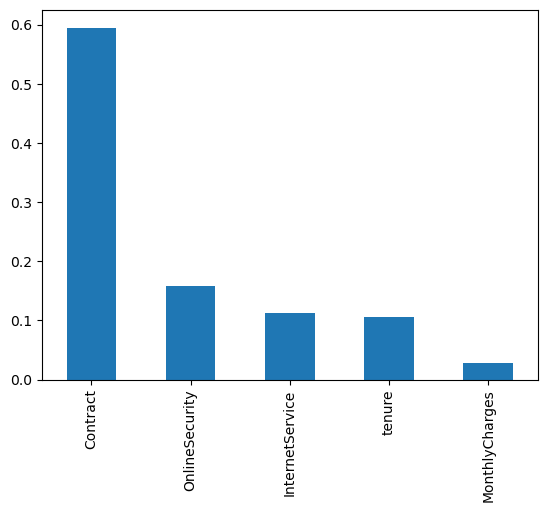

In [33]:
col_names = category_cols + numeric_cols
fi = tree_search.best_estimator_.named_steps['decisiontreeclassifier'].feature_importances_
feature_importances = pd.Series(fi, index=col_names)
feature_importances.sort_values(ascending = False)[:5].plot(kind='bar')

[Text(0.6363636363636364, 0.9166666666666666, 'x[13] <= 0.5\ngini = 0.392\nsamples = 4930\nvalue = [3611, 1319]'),
 Text(0.45454545454545453, 0.75, 'x[7] <= 0.5\ngini = 0.491\nsamples = 2701\nvalue = [1535, 1166]'),
 Text(0.36363636363636365, 0.5833333333333334, 'x[16] <= 7.5\ngini = 0.499\nsamples = 1860\nvalue = [900, 960]'),
 Text(0.18181818181818182, 0.4166666666666667, 'x[6] <= 0.5\ngini = 0.454\nsamples = 751\nvalue = [262, 489]'),
 Text(0.09090909090909091, 0.25, 'gini = 0.5\nsamples = 316\nvalue = [157, 159]'),
 Text(0.2727272727272727, 0.25, 'gini = 0.366\nsamples = 435\nvalue = [105, 330]'),
 Text(0.5454545454545454, 0.4166666666666667, 'x[6] <= 0.5\ngini = 0.489\nsamples = 1109\nvalue = [638, 471]'),
 Text(0.45454545454545453, 0.25, 'gini = 0.332\nsamples = 295\nvalue = [233, 62]'),
 Text(0.6363636363636364, 0.25, 'x[16] <= 16.5\ngini = 0.5\nsamples = 814\nvalue = [405, 409]'),
 Text(0.5454545454545454, 0.08333333333333333, 'gini = 0.467\nsamples = 245\nvalue = [91, 154]'),


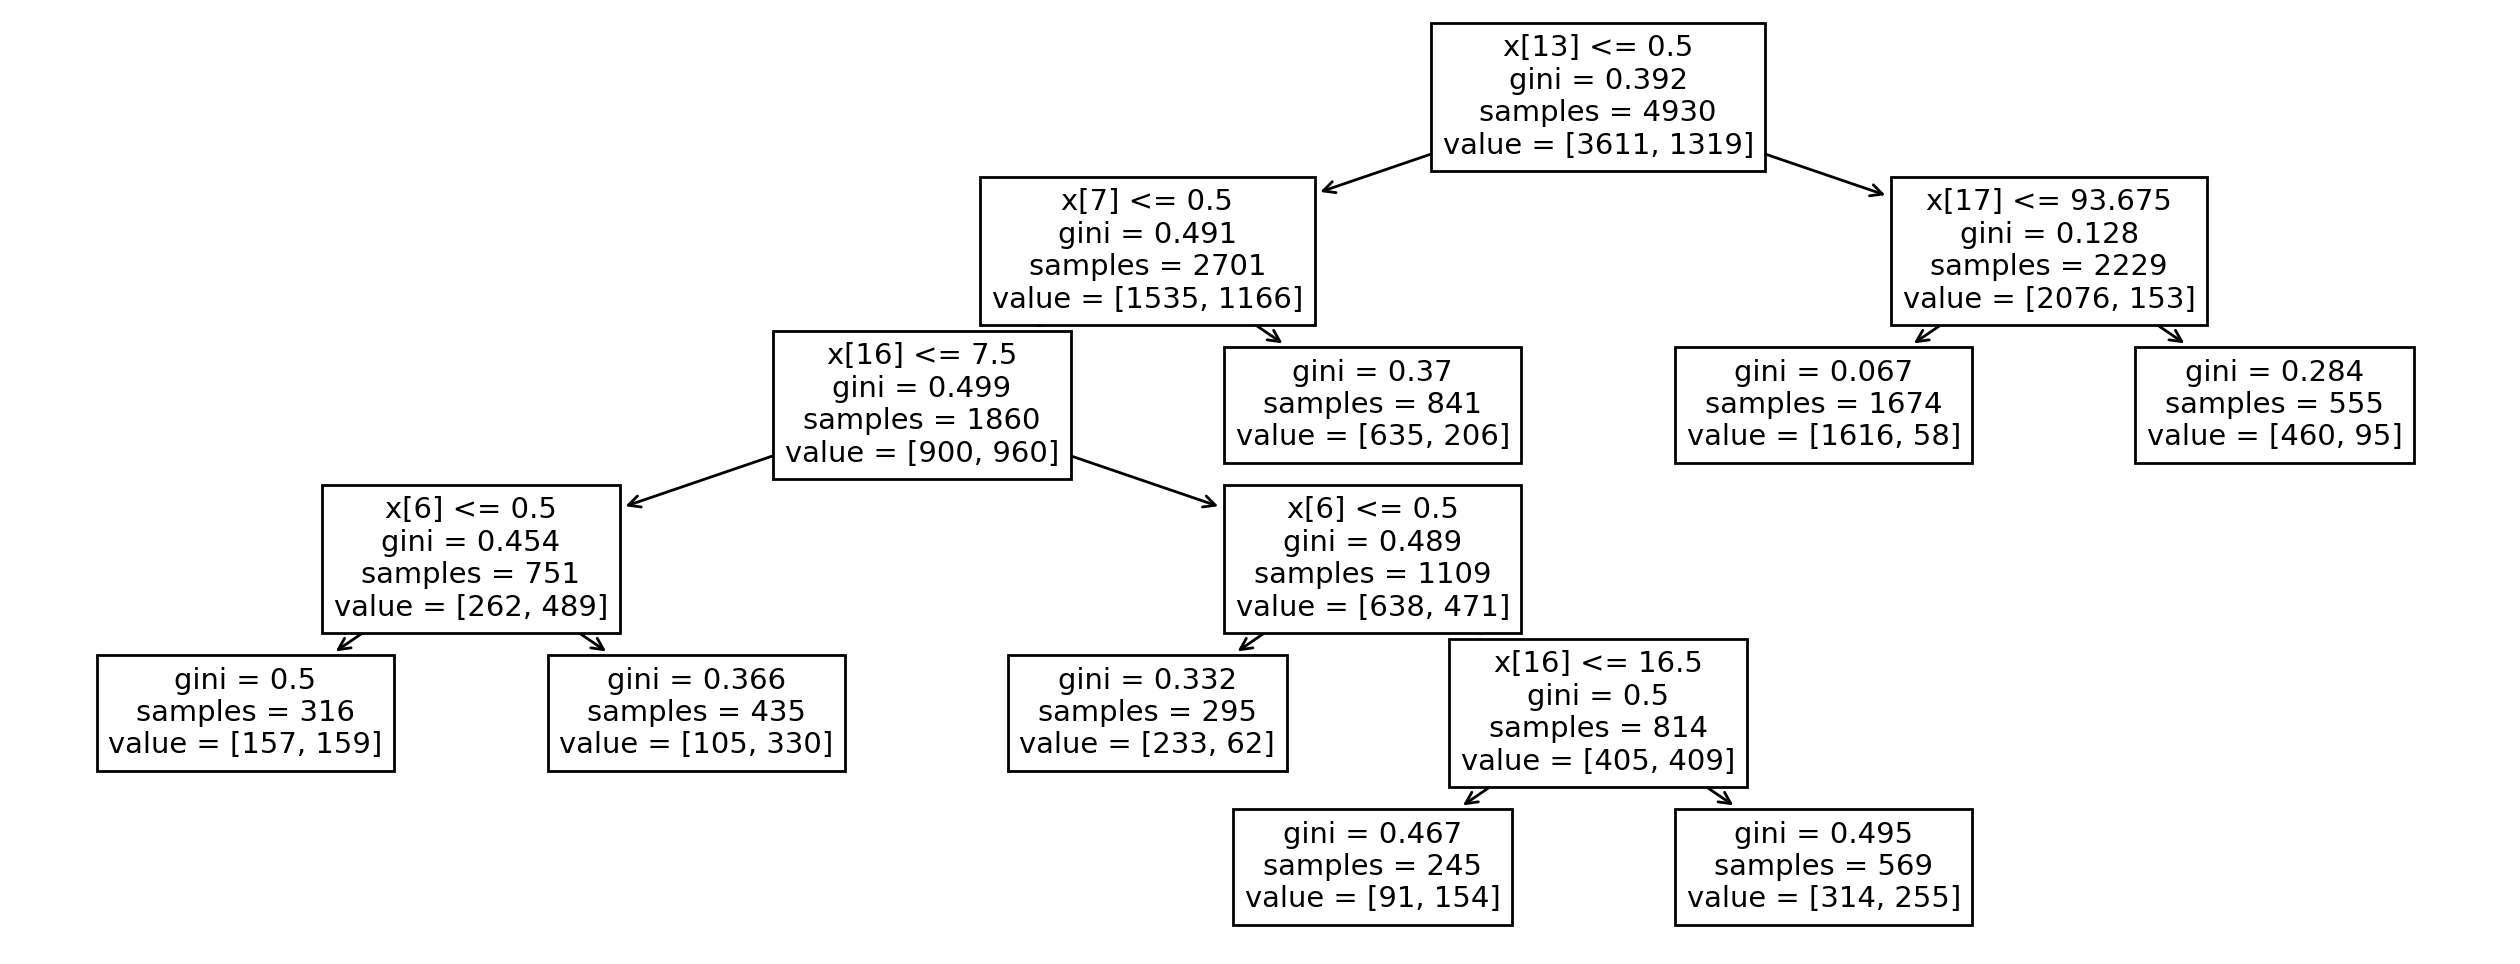

In [34]:
plt.figure(figsize=(16, 6), dpi=200)
tree.plot_tree(tree_search.best_estimator_.named_steps['decisiontreeclassifier'])

In [35]:
cat_rules = tree_search.best_estimator_.named_steps['columntransformer'].named_transformers_['cat'].categories_
col_names[13], cat_rules[13]

('Contract', array(['Month-to-month', 'One year', 'Two year'], dtype=object))

In [36]:
col_names[7], cat_rules[7]

('OnlineSecurity', array(['No', 'No internet service', 'Yes'], dtype=object))

In [37]:
col_names[16]

'tenure'

In [38]:
col_names[6], cat_rules[6]

('InternetService', array(['DSL', 'Fiber optic', 'No'], dtype=object))

The more effective a classification rule is, the lower its corresponding Gini coefficient. We can further explore by extracting the left leaf node of the third layer on the right branch, finding that most non-month-to-month payment users have a higher retention rate, and users with a monthly expenditure less than $92.5 have the highest retention rate. 

越是有效的分类规则，对应的基尼系数越小,我们可以提取右侧分支的第三层左侧叶节点，进一步探索得到大多数非按月付费用户留存率都较大，并且月消费金额小于92.5的用户留存率最大。在按月付费用户中，未购买OnlineSecurity(X[7]<=0.5)，且入网不足8个月(X[16]<=7.5)，且购买了InternetService的用户，流失用户数量是留存用户数量的3倍。

## 单独对时间序列字段分析

In [39]:
feature_seq = pd.DataFrame()
feature_seq['tenure'] = tcc['tenure']

In [40]:
feature_seq['tenure_year'] = ((72 - tcc['tenure']) // 12) + 2014

In [41]:
feature_seq['tenure_month'] = (72 - tcc['tenure']) % 12 + 1

In [42]:
feature_seq['tenure_quarter'] = (((feature_seq['tenure_month'])-1) // 3) + 1

In [43]:
feature_seq['Churn'] = tcc['Churn']
feature_seq.head()

,tenure,tenure_year,tenure_month,tenure_quarter,Churn
0,1,2019,12,4,0
1,34,2017,3,1,0
2,2,2019,11,4,1
3,45,2016,4,2,0
4,2,2019,11,4,1


In [44]:
seq_new = ['tenure_year','tenure_month','tenure_quarter']
feature_seq_new = feature_seq[seq_new]
feature_seq_new.head()

,tenure_year,tenure_month,tenure_quarter
0,2019,12,4
1,2017,3,1
2,2019,11,4
3,2016,4,2
4,2019,11,4


In [45]:
enc = preprocessing.OneHotEncoder()
enc.fit_transform(feature_seq_new)

<7043x23 sparse matrix of type '<class 'numpy.float64'>'
	with 21129 stored elements in Compressed Sparse Row format>

In [46]:
features_seq_new = pd.DataFrame(enc.fit_transform(feature_seq_new).toarray(), 
                               columns = cate_colName(enc, seq_new, drop=None))
features_seq_new['Churn'] = tcc['Churn']
features_seq_new.head()

,tenure_year_2014,tenure_year_2015,tenure_year_2016,tenure_year_2017,tenure_year_2018,tenure_year_2019,tenure_year_2020,tenure_month_1,tenure_month_2,tenure_month_3,...,tenure_month_8,tenure_month_9,tenure_month_10,tenure_month_11,tenure_month_12,tenure_quarter_1,tenure_quarter_2,tenure_quarter_3,tenure_quarter_4,Churn
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1


<Axes: >

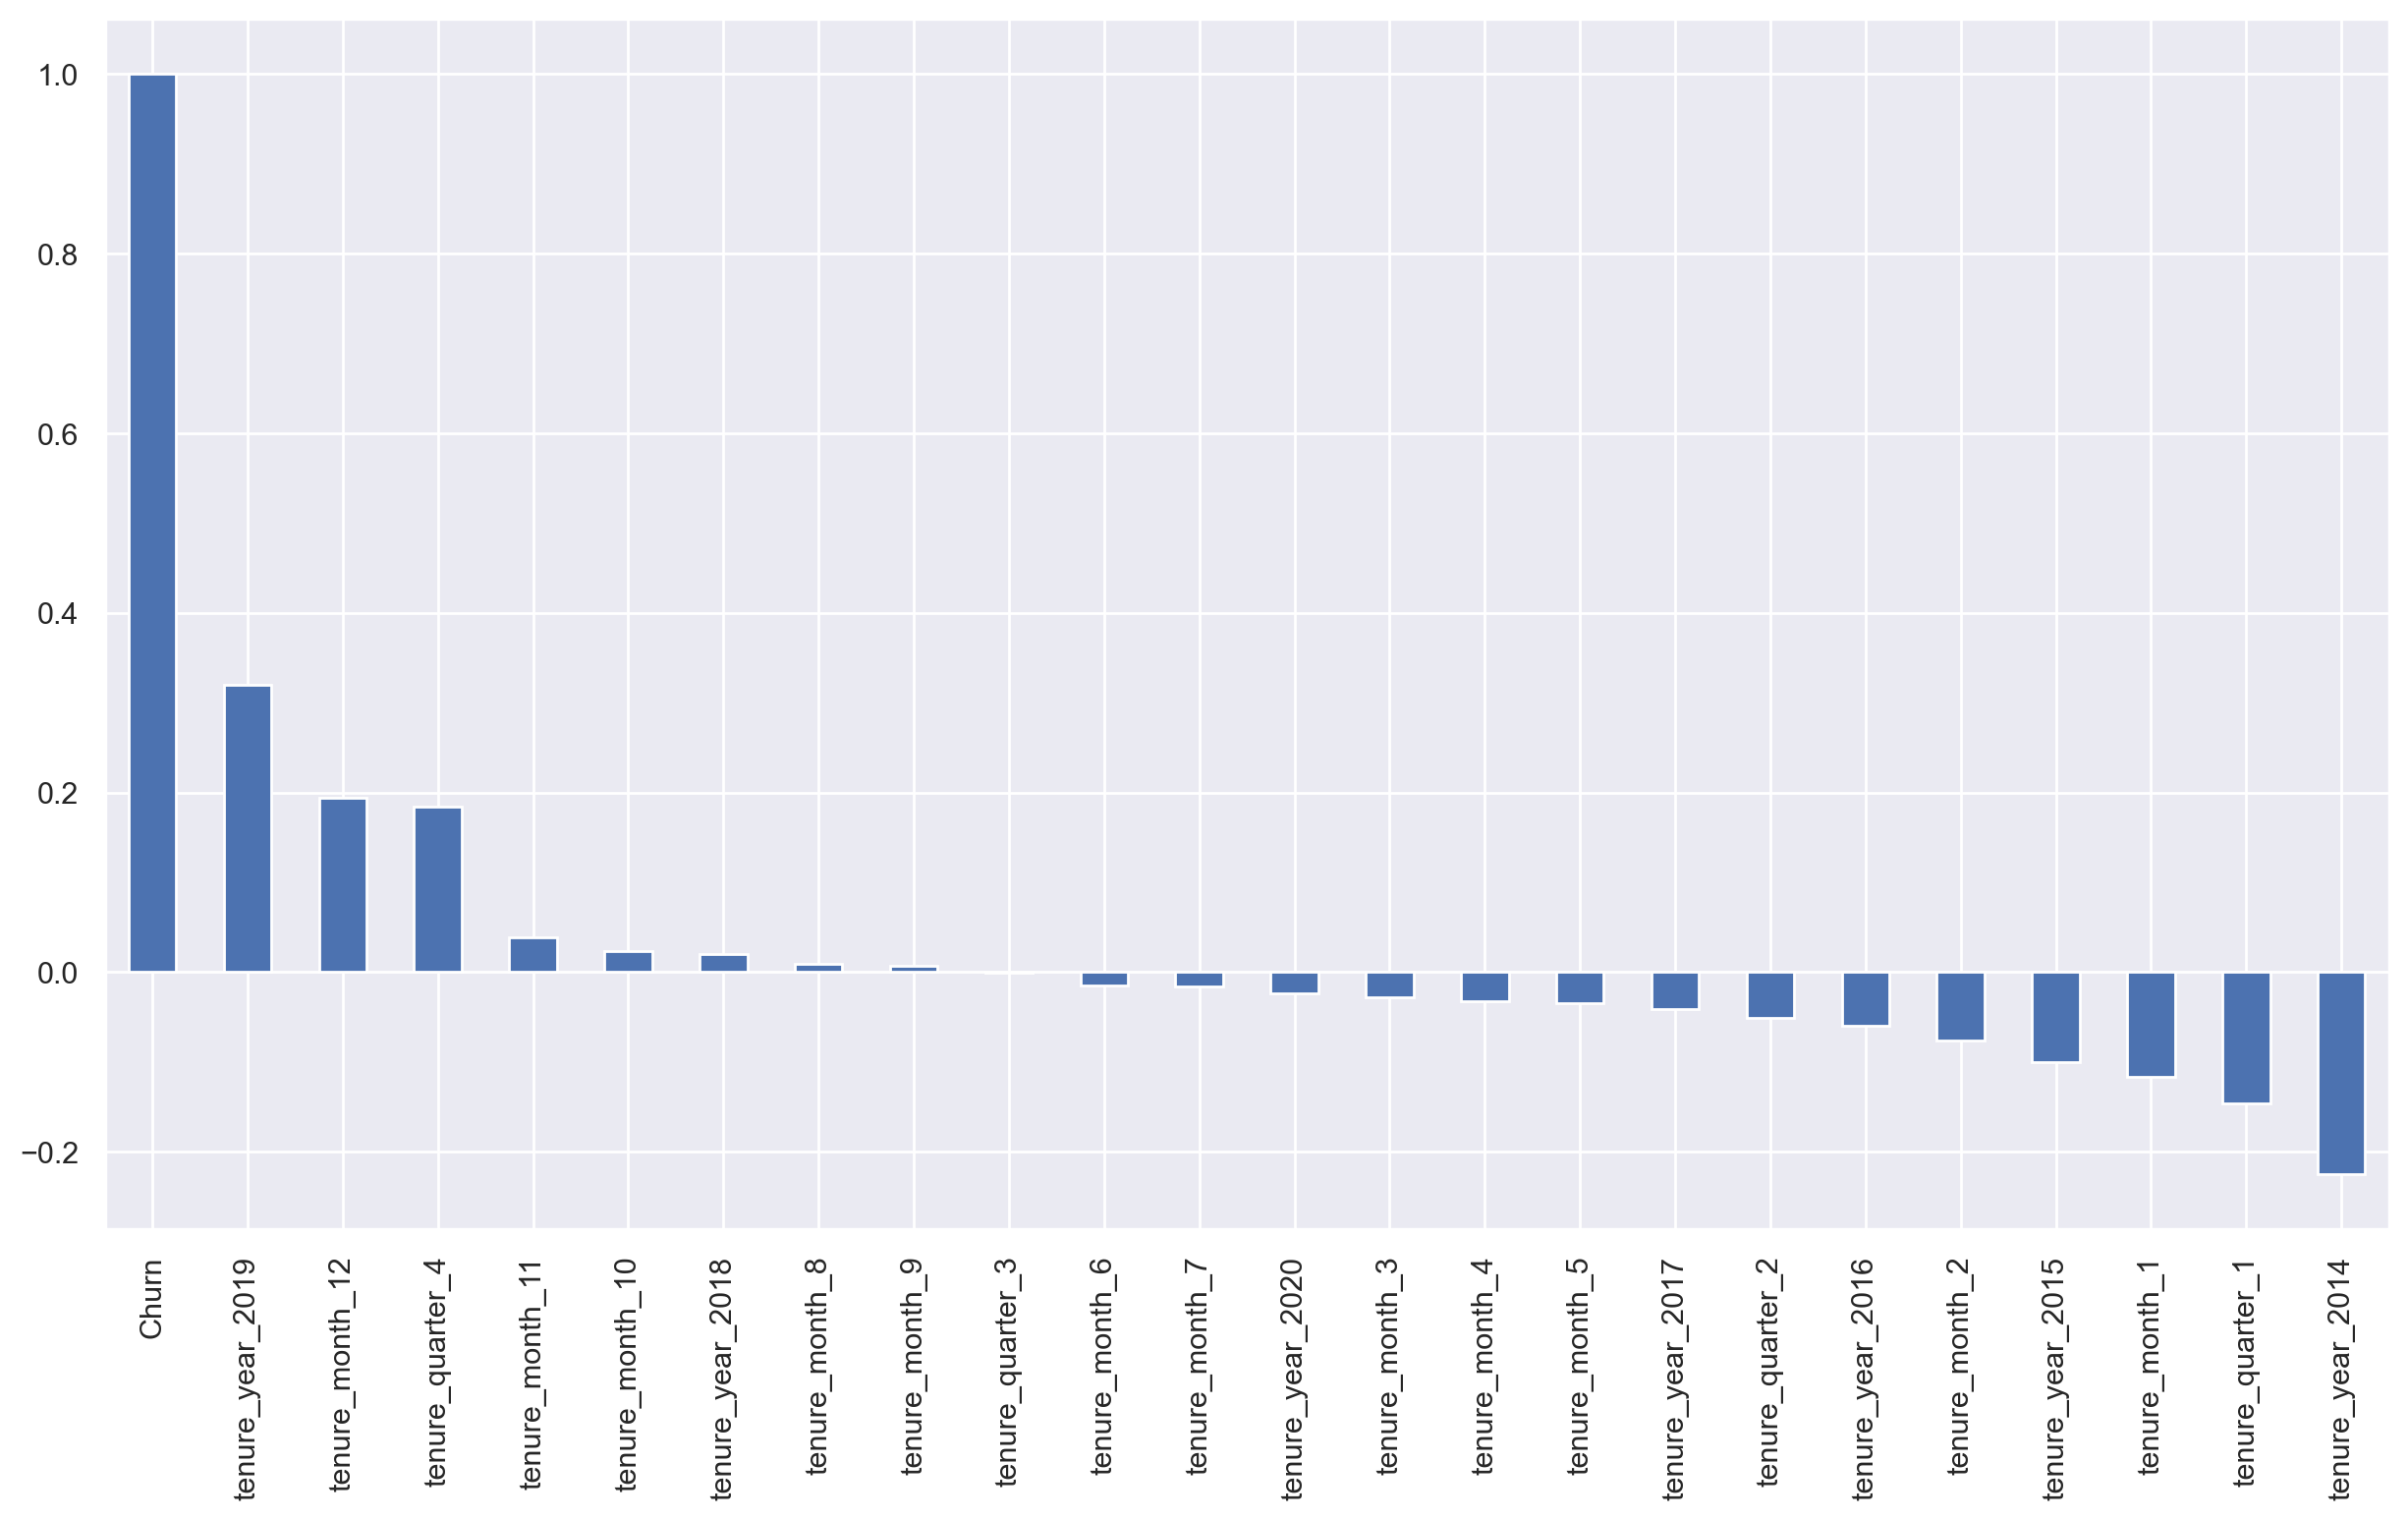

In [47]:
sns.set()
plt.figure(figsize=(15,8), dpi=200)

features_seq_new.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

It can be observed that users who joined the network in 2019 generally have a higher churn rate, while those who joined in 2014 have a lower churn rate. This trend is consistent with the correlation observed between the tenure field and the label, indicating that the newer the users to the network, the higher their probability of churn. Users who join in December and the fourth quarter are more prone to churn, whereas those who join in January and the first quarter tend to have a relatively lower churn rate.

能够看出，2019年入网用户普遍流失率更大、而2014年入网用户普遍流失率更小，当然这个和tenure字段与标签的相关性表现出来的规律是一致的，即越是新入网的用户、流失概率越大，我们需要更关注例如12月和第四季度入网用户普遍容易流失、而1月和第一季度入网用户流失率相对较低这类规律。

## Business Strategy Formulation

1. Customized service plans for specific user groups: Design more attractive and promotional policies for elderly users, unmarried users, and economically dependent users, such as offering special discounts or setting up dedicated customer service channels.
2. Value-added service bundling promotion: For users who have not subscribed to Internet services, launch trial packages or bundled sales for Internet services to encourage them to experience and subscribe. For those users who have enabled network services but not other value-added services, free trial periods or discount promotions for value-added services can be offered to increase their interest in these services.
3. Payment experience optimization: Address the high churn rate among online payment users by improving the online payment process to ensure security and convenience during payment.
4. Contract flexibility and loyalty programs: For month-to-month payment users, provide more flexible contract options, such as allowing them to upgrade or downgrade services without extra fees. For long-term contract users, offer loyalty rewards, such as discounted service upgrades, additional value-added service experiences, etc.
5. Promotion and education of cybersecurity services: Enhance the promotion of cybersecurity services, demonstrating their importance and benefits, especially to users who have been with the network for less than 8 months. Conduct cybersecurity education activities to raise users' security awareness, thereby increasing their demand for cybersecurity services.
6. Seasonal promotions: For users who join in December and the fourth quarter, launch special New Year promotions or loyalty programs, such as offering extra data bundles, discounted value-added services, or customized package deals.
7. Enhancing the initial user experience for new sign-ups: For users who join in the fourth quarter, provide more guidance and support to help them better understand and use the services. Offer additional customer service support in the first few months of subscription to ensure their queries and issues are quickly addressed.

## 业务调整与策略制定

- 用户流失规律总结

老年用户、未结婚用户以及经济未独立用户流失比例相对较高，而性别因素对是否流失影响不大。未开通网络服务的用户、以及开通了网络服务并且同时开通很多增值服务的用户往往流失概率较小，而开通网络服务、未开通其他增值服务的用户流失概率较大。相比其他支付方式，在线支付的用户更容易流失。大多数非合同签订方式按月用户留存率都较大，并且月消费金额小于92.5的用户留存率最大。在按月签订合同的用户中，未购买网络安全服务，且入网时间不足8个月，且购买了网络服务的用户，流失用户数量是留存用户数量的3倍。12月和第四季度入网用户普遍容易流失、而1月和第一季度入网用户流失率相对较低。

- 业务策略制定

1.**针对特定用户群体的定制服务计划**：对于老年用户、未结婚用户和经济未独立用户，设计更具吸引力的套餐和优惠政策，例如提供特别折扣或者设立专门的客户服务渠道。

2.**增值服务捆绑推广**：针对那些未开通网络服务的用户，推出网络服务试用套餐或捆绑销售，鼓励他们体验和订购。对于已开通网络服务但未开通其他增值服务的用户，可以提供增值服务的免费试用期或打折促销，以提高他们对这些服务的兴趣。

**3.优化支付体验**：针对在线支付用户的高流失率，改善在线支付流程，确保支付过程的安全和便利。

**4.合同灵活性和忠诚度计划**：对于按月付费的用户，提供更灵活的合同选择，如允许他们在无额外费用的情况下升级或降级服务。对于长期合同用户，提供忠诚度奖励，如优惠升级服务、额外的增值服务体验等。

**5.网络安全服务的推广和教育**：加强对网络安全服务的宣传，向用户展示其重要性和益处，尤其是针对入网时间不足8个月的用户。开展网络安全教育活动，提高用户的安全意识，从而增加他们对网络安全服务的需求。

**6.季节性促销**：对于在12月和第四季度入网的用户，推出特别的新年促销或忠诚度计划，如提供额外的数据包、优惠的增值服务或者是定制的套餐优惠。

**7.增强入网初期的用户体验**：对于第四季度入网的用户，提供更多的引导和支持，帮助他们更好地了解和使用服务。在入网的前几个月内，提供额外的客户服务支持，确保他们的疑问和问题能够得到快速解答。